In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
%matplotlib inline

In [132]:
data=pd.read_csv('/content/train.csv')
data.head()

<ipython-input-132-526ec695bc6c>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/content/train.csv')


ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   Outstanding_Debt Credit_Utilization_Ratio     Credit_History_Age  \
0            809.98                26.822620  22 Years and 1 Months   
1            809.98                31.944960                    NaN   
2            809.98                28.609352  22 Years and 3 Months   
3            809.98                31.377862  22 Years and 4 Months   
4            809.98                24.797347  22 Years and 5 Months   

   Payment_of_Min_Amount Total_EMI_per_month Amount_invested_monthly  \
0                     No           49.574949       80.41529543900253   
1                     No           49.574949      118.28022162236736   
2                     No           49.574949         81.699521264648   
3                     No           49.574949       199.4580743910713   
4                     No           49.574949      41.420153086217326   

                  Payment_Behaviour     Monthly_Balance Credit_Score  
0   High_spent_Small_value_payments  312.49408867943663         Good  
1    Low_spent_Large_value_payments  284.62916249607184         Good  
2   Low_spent_Medium_value_payments   331.2098628537912         Good  
3    Low_spent_Small_value_payments  223.45130972736786         Good  
4  High_spent_Medium_value_payments  341.48923103222177         Good  

[5 rows x 28 columns]

Handling the Object data type features


In [133]:
#Dropping the features that is non relatable with the target
data.drop(['ID','Customer_ID','SSN','Month','Name','Changed_Credit_Limit'],axis=1 , inplace=True)

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  object 
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  object 
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  object 
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   object 
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  ob

There is some features that has Dtype of object while they are numerical features


In [135]:
#Changing the object features from object to numerical
num_features=['Age','Annual_Income','Num_of_Loan','Num_of_Delayed_Payment','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance']

for feature in num_features:
  data[feature]=data[feature].replace('[^-0-9.]','',regex=True).astype('float64',errors='ignore')

#Chosing the age range from 10 to 100
data['Age']=data['Age'][(10<data['Age'])&(data['Age']<100)]

In [136]:
#Extracting the years and the months only from the Credit history age
years_month=data['Credit_History_Age'].str.extract(r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?')
#Changing the data type to numerical
years=pd.to_numeric(years_month[0],errors='coerce').fillna(0)
months=pd.to_numeric(years_month[1],errors='coerce').fillna(0)
#Adding years and months together
data['Credit_History_Age']=(years*12+months)//12

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       97223 non-null   float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  float64
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   float64
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  fl

In [138]:
#Using OneHotEncoder to Turn Categories to Numbers
one_hot=OneHotEncoder()

#Selecting Features that need to be changed
cat_features=['Occupation','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour']

transform=ColumnTransformer([('one hot',one_hot,cat_features)],remainder='passthrough')
transformed_df=transform.fit_transform(data[cat_features])


In [139]:
#Making a new Df with the new columns
new_data=pd.DataFrame(transformed_df)

#Getting the old and the new features names
new_data=pd.get_dummies(data[cat_features],columns=cat_features)
new_data.head()

Occupation_Accountant  Occupation_Architect  Occupation_Developer  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   Occupation_Doctor  Occupation_Engineer  Occupation_Entrepreneur  \
0                  0                    0                        0   
1                  0                    0                        0   
2                  0                    0                        0   
3                  0                    0                        0   
4                  0                    0                        0   

   Occupation_Journalist  Occupation_Lawyer  Occupation_Manager  \
0                      0                  0                   0   
1                      0                  0                   0   
2                      0                  0                   0   
3                      0                  0                   0   
4                      0                  0                   0   

   Occupation_Mechanic  ...  Payment_of_Min_Amount_NM  \
0                    0  ...                         0   
1                    0  ...                         0   
2                    0  ...                         0   
3                    0  ...                         0   
4                    0  ...                         0   

   Payment_of_Min_Amount_No  Payment_of_Min_Amount_Yes  \
0                         1                          0   
1                         1                          0   
2                         1                          0   
3                         1                          0   
4                         1                          0   

   Payment_Behaviour_!@9#%8  \
0                         0   
1                         0   
2                         0   
3                         0   
4                         0   

   Payment_Behaviour_High_spent_Large_value_payments  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Payment_Behaviour_High_spent_Medium_value_payments  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  1    

   Payment_Behaviour_High_spent_Small_value_payments  \
0                                                  1   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Payment_Behaviour_Low_spent_Large_value_payments  \
0                                                 0   
1                                                 1   
2                                                 0   
3                                                 0   
4                                                 0   

   Payment_Behaviour_Low_spent_Medium_value_payments  \
0                                                  0   
1                                                  0   
2                                                  1   
3                                                  0   
4                                                  0   

   Payment_Behaviour_Low_spent_Small_value_payments  
0                                                 0  
1                                                 0  
2                   

In [140]:
#Transforming the last column and adding it to the new data
new_data = new_data.join(data['Type_of_Loan'].replace('and ', '', regex=True).str.get_dummies(', '))
new_data.drop('Occupation________',axis=1,inplace=True)
new_data.head()

Occupation_Accountant  Occupation_Architect  Occupation_Developer  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   Occupation_Doctor  Occupation_Engineer  Occupation_Entrepreneur  \
0                  0                    0                        0   
1                  0                    0                        0   
2                  0                    0                        0   
3                  0                    0                        0   
4                  0                    0                        0   

   Occupation_Journalist  Occupation_Lawyer  Occupation_Manager  \
0                      0                  0                   0   
1                      0                  0                   0   
2                      0                  0                   0   
3                      0                  0                   0   
4                      0                  0                   0   

   Occupation_Mechanic  ...  Payment_Behaviour_Low_spent_Small_value_payments  \
0                    0  ...                                                 0   
1                    0  ...                                                 0   
2                    0  ...                                                 0   
3                    0  ...                                                 1   
4                    0  ...                                                 0   

   Auto Loan  Credit-Builder Loan  Debt Consolidation Loan  Home Equity Loan  \
0          1                    1                        0                 1   
1          1                    1                        0                 1   
2          1                    1                        0                 1   
3          1                    1                        0                 1   
4          1                    1                        0                 1   

   Mortgage Loan  Not Specified  Payday Loan  Personal Loan  Student Loan  
0              0              0            0              1             0  
1              0              0            0              1             0  
2              0              0            0              1             0  
3              0              0            0              1             0  
4              0              0            0              1             0  

[5 rows x 38 columns]

In [141]:
#Assigning My features to x and my target to y
data.drop('Type_of_Loan',axis=1,inplace=True)
data=data.drop(columns=cat_features)

x=data.drop('Credit_Score',axis=1)

y=data['Credit_Score']

In [142]:
#filling the null values
x=x.fillna(x.mean())

y=y.fillna(y.mode())

In [144]:
#Changing the target from categorical to numerical
y=y.replace(['Good','Standard','Poor'],[1,2,0])

Now we have 3 main variables with are x,y and new_data we will work on the x and y for now and will add the new_data later on

In [146]:
#dividing my data to train and test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2 , random_state=42)

Checking for outliers in our features

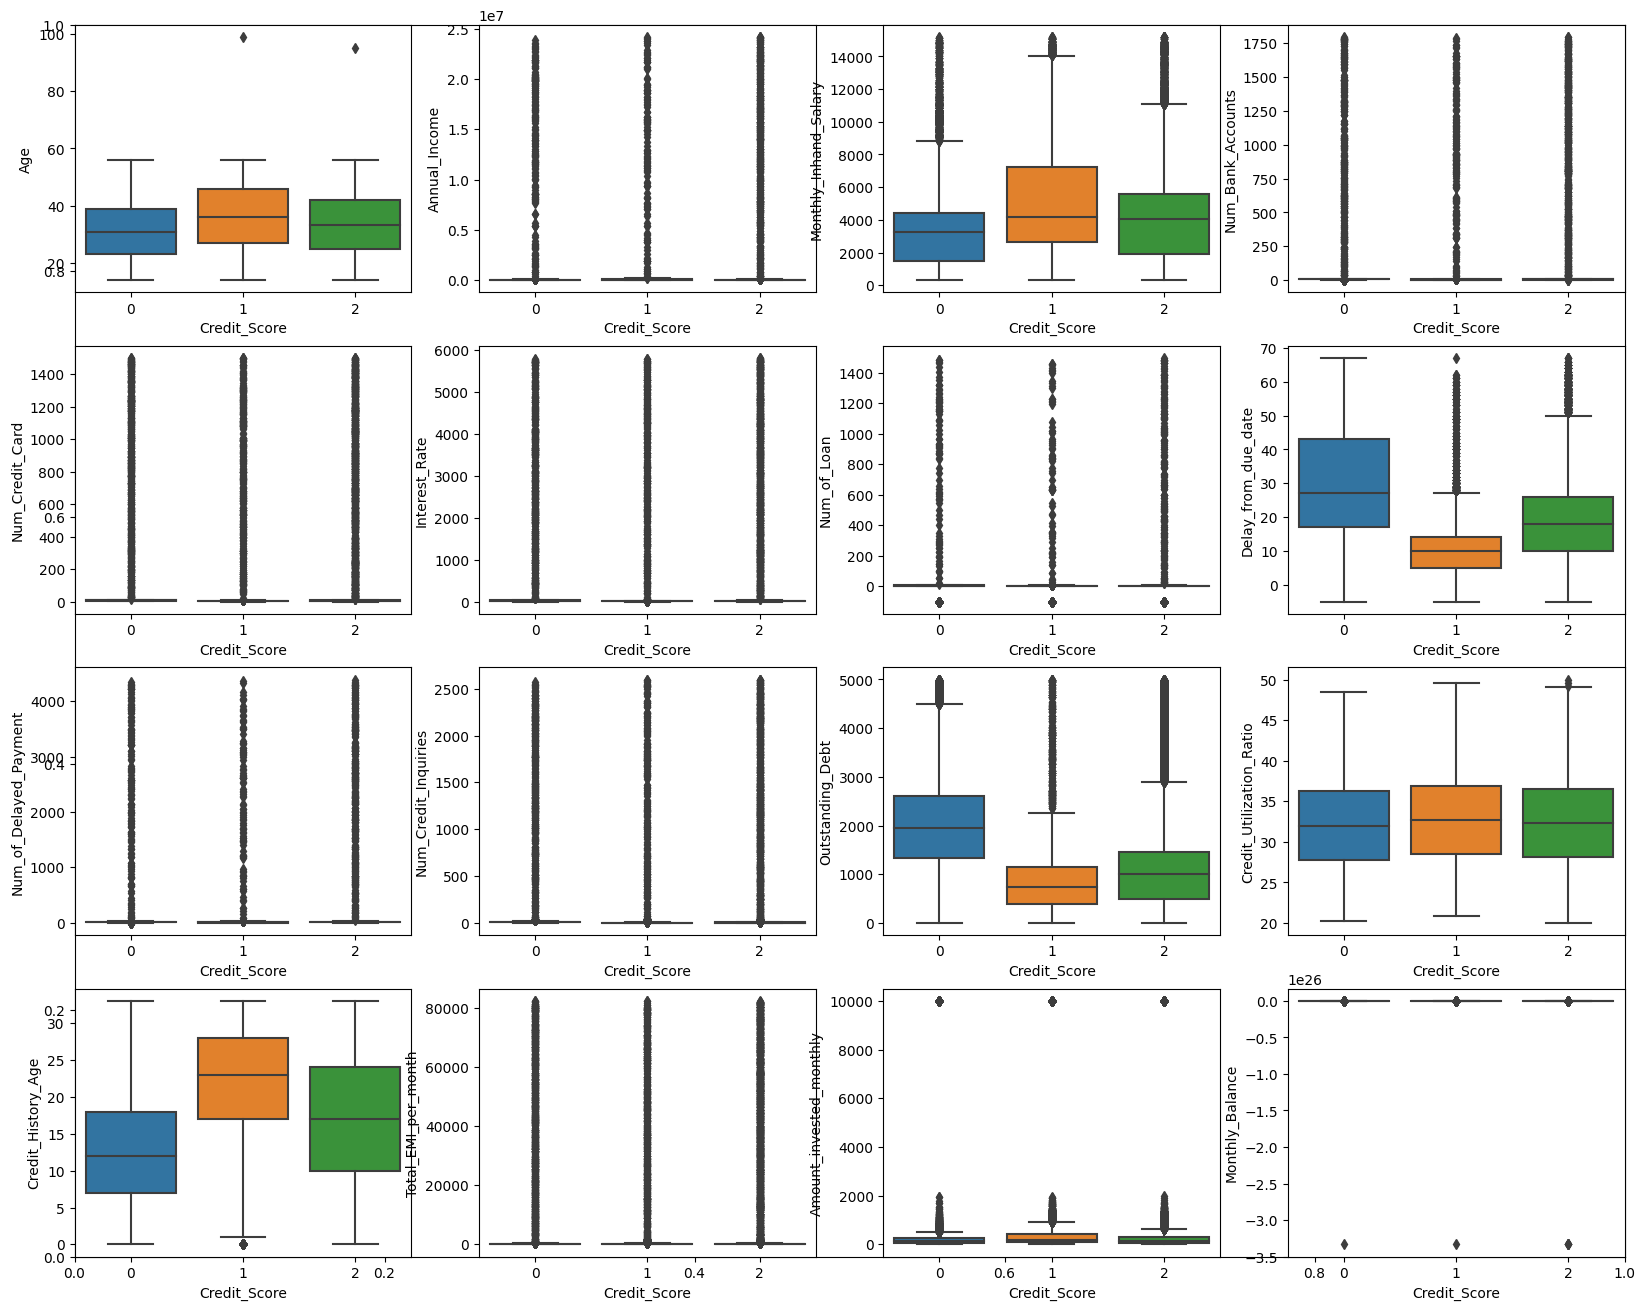

In [148]:
fig, ax = plt.subplots(figsize=(20, 16))
for i, feature in enumerate(x_train.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    sns.boxplot(x_train.join(y_train), x="Credit_Score", order=[0, 1, 2], y=feature, ax=ax)

In [155]:
outliers_df=pd.DataFrame()
for col in x_train.columns:
  iqr_multiplier=1.5
  Q1=x_train[col].quantile(0.25)
  Q3=x_train[col].quantile(0.75)
  IQR=Q3-Q1


  lower_bound=Q1 - iqr_multiplier * IQR
  upper_bound=Q3 + iqr_multiplier * IQR

  outliers_df[col]=(x_train[col]< lower_bound) | (x_train[col]> upper_bound)

  x_train=x_train[~outliers_df.any(axis=True)]

print(f"Removing {len(x_train[outliers_df.any(axis=1)])} of {len(x_train)} rows.")


<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train=x_train[~outliers_df.any(axis=True)]
<ipython-input-155-c63ae0a4aa90>:14: Use

Removing 0 of 44237 rows.


<ipython-input-155-c63ae0a4aa90>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Removing {len(x_train[outliers_df.any(axis=1)])} of {len(x_train)} rows.")


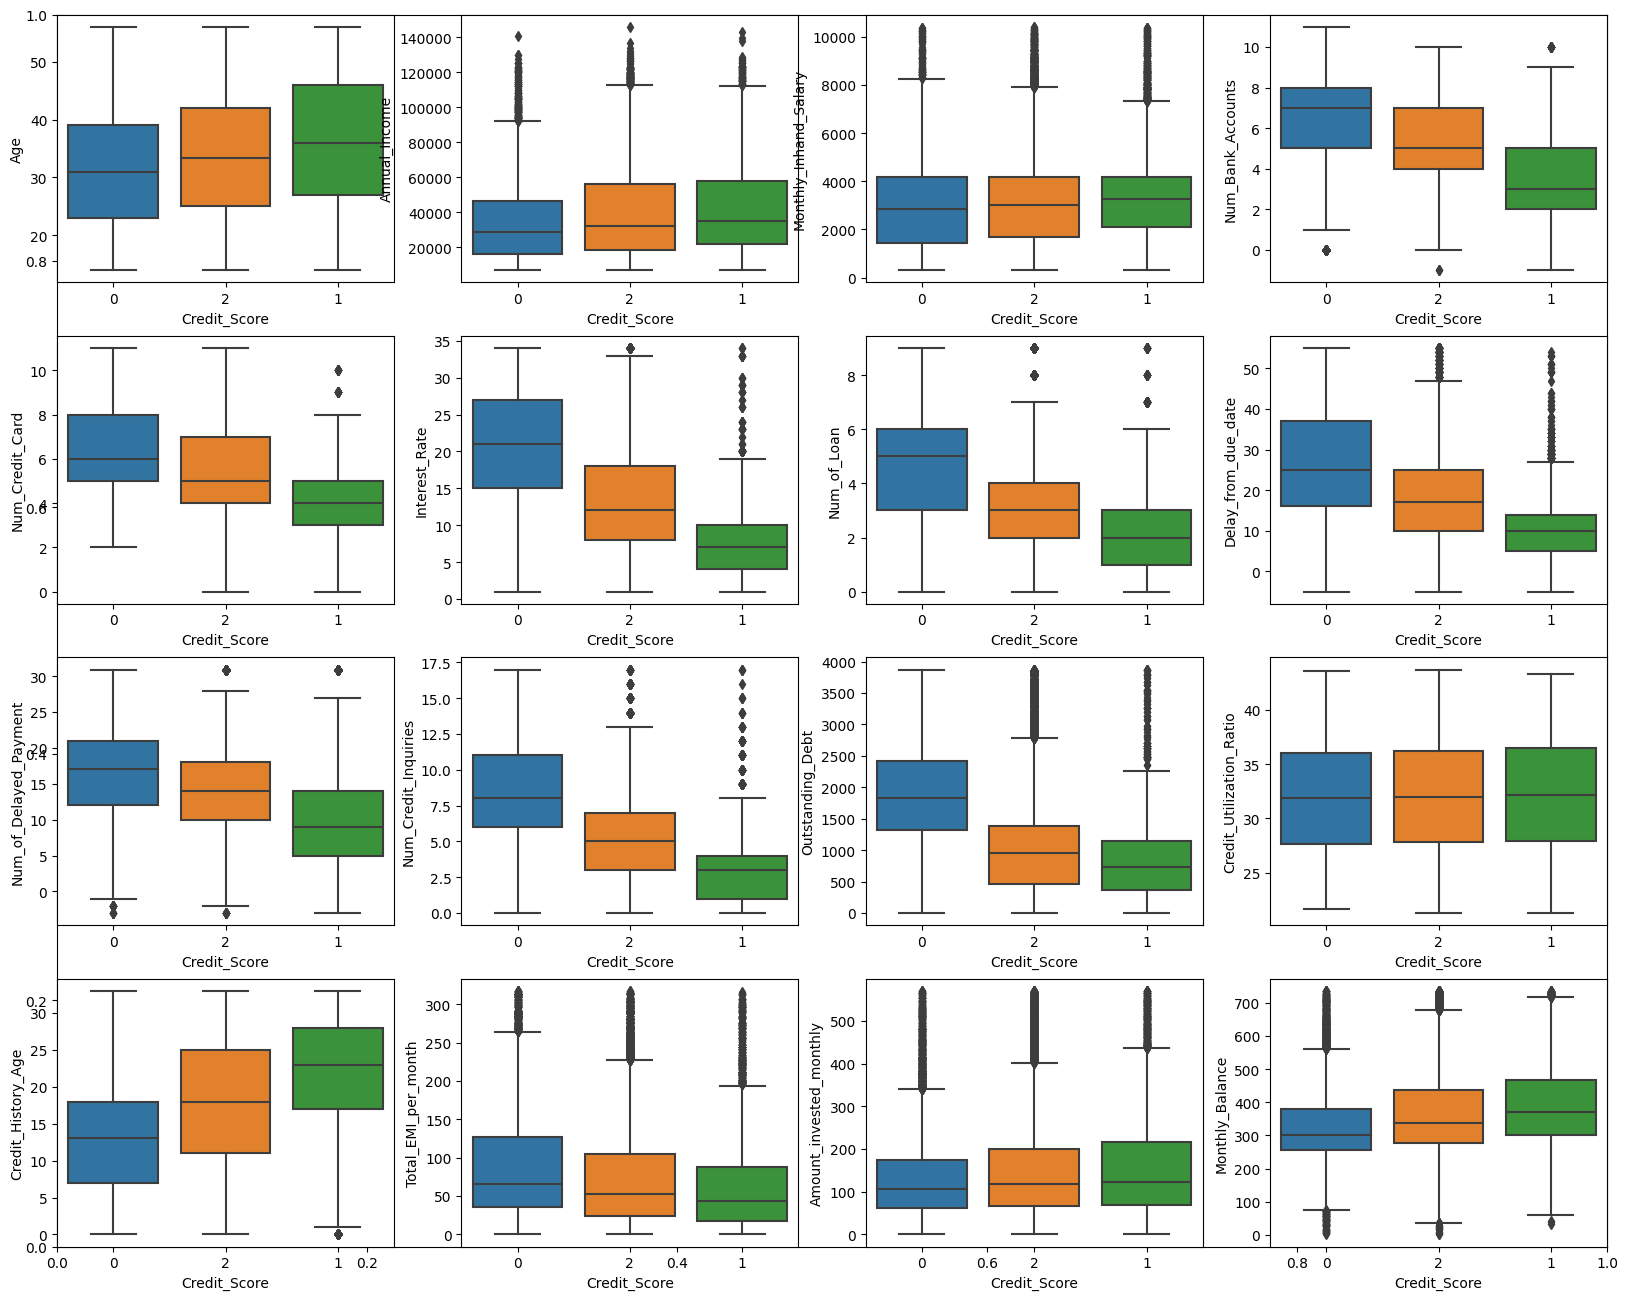

In [156]:
#ploting again to check for the outliers
fig, ax = plt.subplots(figsize=(20, 16))
for i, feature in enumerate(x_train.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    sns.boxplot(x_train.join(y_train), x="Credit_Score", order=[0, 2, 1], y=feature, ax=ax)


<Axes: >

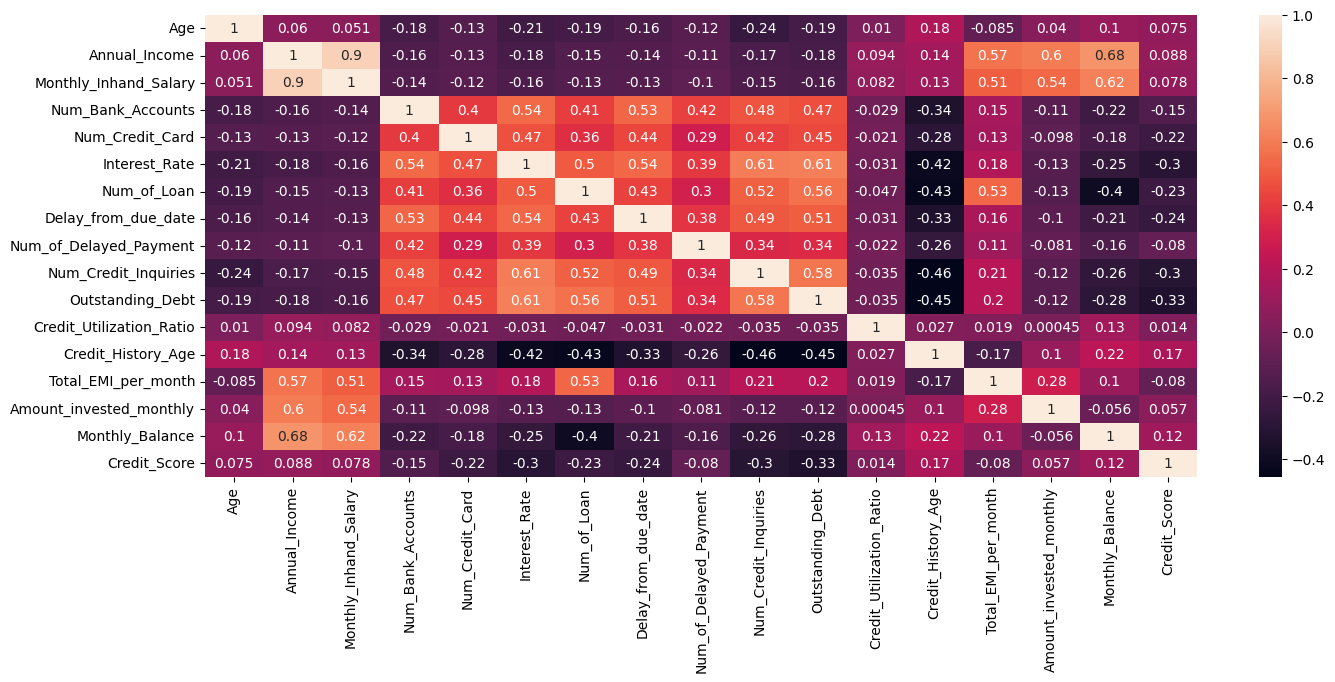

In [160]:
#Checking for Correlation

fig=plt.figure(figsize=(16,6))
matrix=x_train.join(y_train).corr()
sns.heatmap(matrix,annot=True)

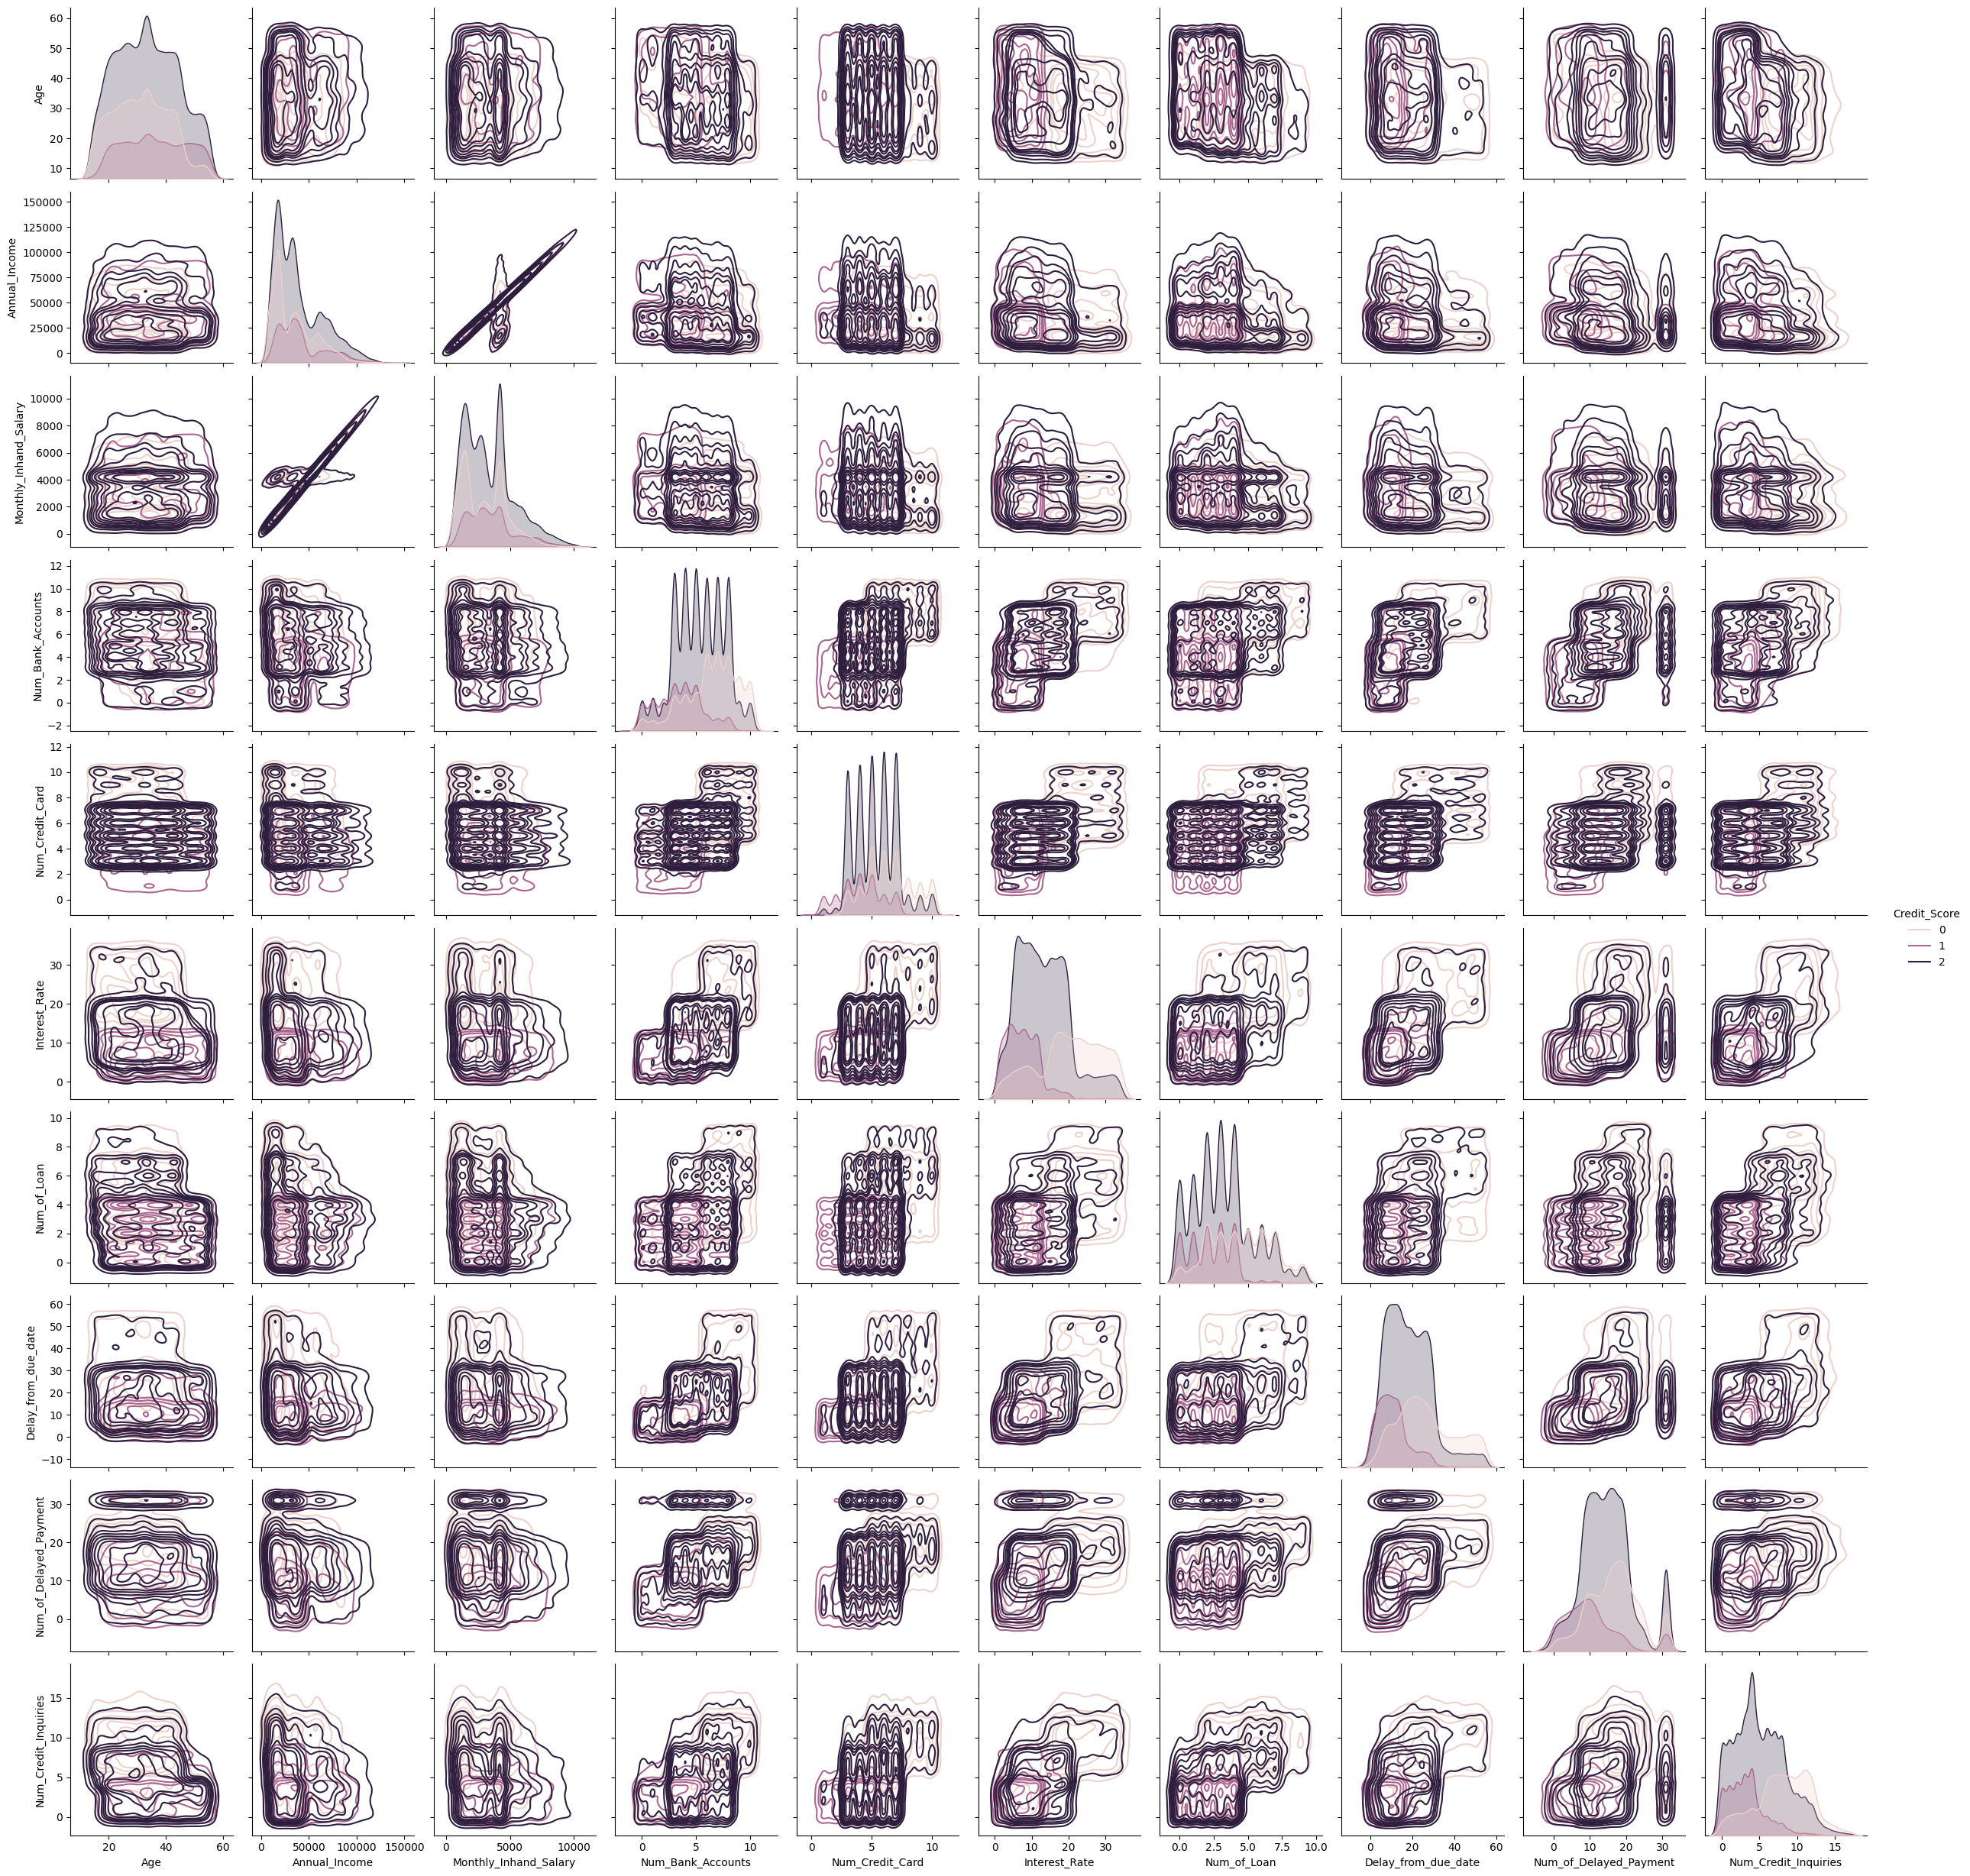

In [161]:
sns.pairplot(x_train.iloc[:, :10].join(y_train), hue='Credit_Score', kind="kde")

Lets add the one hot encoded data to the x

In [162]:
x_train=x_train.join(new_data)
x_test=x_test.join(new_data)
y_train=y_train[x_train.index]

Trying The KNearstNeighbors Classifier

In [173]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)

In [174]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.62075


It seems like we didnt get much of an accuracy
Lets now try RandomForset classifier

In [184]:
print("Precision for labels: ", precision_score(pd.Series(rfc.predict(x_test)), y_test, average=None))

Precision for labels:  [0.75621382 0.83328608 0.53948486]


In [179]:
rfc=RandomForestClassifier(max_depth=3 , random_state=42 , n_estimators=100 , n_jobs=-1,class_weight='balanced')

rfc.fit(x_train,y_train)

score=rfc.score(x_train,y_train)
print(score)

0.6865293758618352
